# Step 0: Import Datasets

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

# Step 1: Define dataloader and visualization

In [5]:
#First let's define our data augmentation rules or transforms

# define transformations for train
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=.30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
# for test we dont need much of augmentations other than converting to tensors and normalizing the pictures
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [6]:
train_data = datasets.CIFAR10('./cifar10/', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('./cifar10/', train=False,
                             download=True, transform=test_transform)

In [7]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 30

# percentage of training set to use as validation
valid_size = 0.2

In [8]:
# Dividing the training dataset further for validation set
num_train = len(train_data)
indices = list(range(num_train))
#print(num_train)
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
#print(len(train_idx), len(valid_idx))

In [9]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [10]:
#  data loaders (combine dataset and sampler)
#Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [11]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Visualizations

In [12]:
#  function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

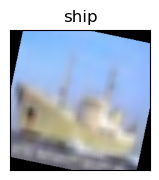

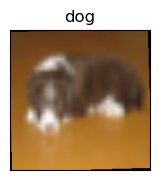

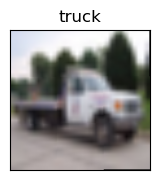

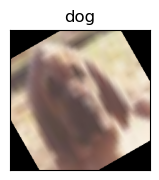

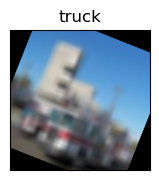

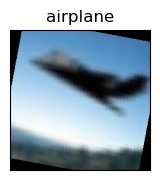

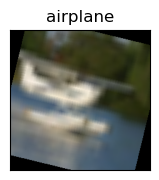

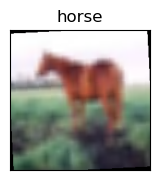

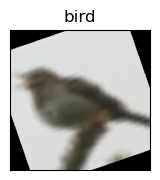

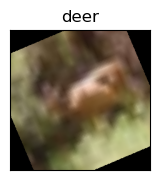

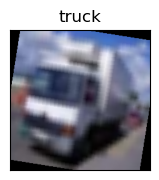

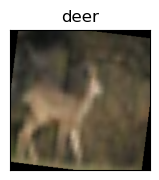

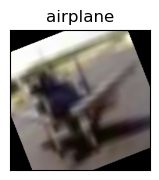

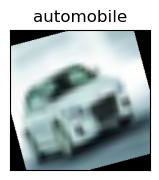

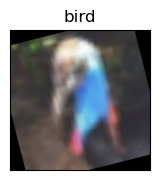

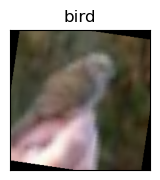

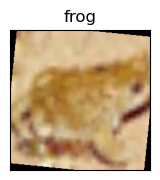

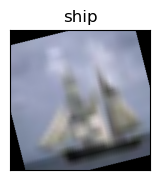

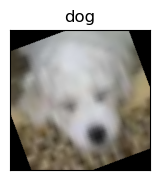

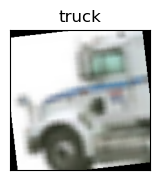

In [13]:
#  one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels

# display 20 images
for idx in np.arange(20):
    fig = plt.figure(figsize=(25, 4))
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
    plt.show()

# Step 2: Use AlexNet for Transfer Learning

In [14]:
model_transfer =  models.alexnet(pretrained=True)

In [15]:
print(model_transfer)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
# freeze pre-trained model weight
for param in model_transfer.parameters():
    param.requires_grad = False

# replace the last fully connected layer with a new fully connected layer
in_features = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(in_features, 10)

use_gpu = torch.cuda.is_available()
if use_gpu:
    model_transfer = model_transfer.cuda()

In [17]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [18]:
from torchsummary import summary
summary(model_transfer, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [19]:
criterion = nn.CrossEntropyLoss()

# Increased learning-rate for the final fully connected
pretrained_params = []
new_params = []

for name, param in model_transfer.named_parameters():
  if "fc" in name:
    new_params.append(param)
  else:
    pretrained_params.append(param)

optimizer = torch.optim.Adam(
    [{'params': pretrained_params, 'lr': 0.001},
    {'params': new_params, 'lr': 0.1}])

In [20]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model_transfer.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model_transfer.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.400369 	Validation Loss: 1.133776
Validation loss decreased (inf --> 1.133776).  Saving model ...
Epoch: 2 	Training Loss: 1.323428 	Validation Loss: 1.093757
Validation loss decreased (1.133776 --> 1.093757).  Saving model ...
Epoch: 3 	Training Loss: 1.319002 	Validation Loss: 1.076223
Validation loss decreased (1.093757 --> 1.076223).  Saving model ...
Epoch: 4 	Training Loss: 1.321126 	Validation Loss: 1.069269
Validation loss decreased (1.076223 --> 1.069269).  Saving model ...
Epoch: 5 	Training Loss: 1.321474 	Validation Loss: 1.075447
Epoch: 6 	Training Loss: 1.312032 	Validation Loss: 1.048744
Validation loss decreased (1.069269 --> 1.048744).  Saving model ...
Epoch: 7 	Training Loss: 1.316052 	Validation Loss: 1.073923
Epoch: 8 	Training Loss: 1.312955 	Validation Loss: 1.085496
Epoch: 9 	Training Loss: 1.312140 	Validation Loss: 1.044258
Validation loss decreased (1.048744 --> 1.044258).  Saving model ...
Epoch: 10 	Training Loss: 1.311234 	Valida

# Step 3: Test

In [21]:
# Load the saved model
model_transfer.load_state_dict(torch.load('./model_transfer_cifar.pt'))

<All keys matched successfully>

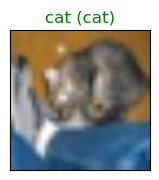

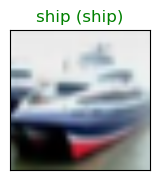

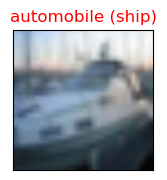

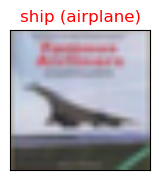

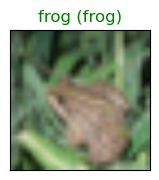

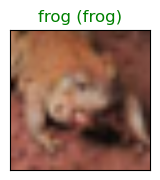

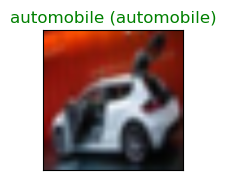

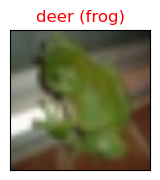

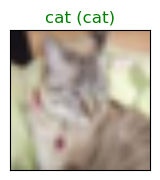

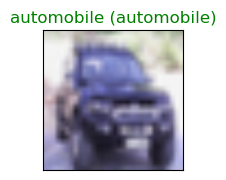

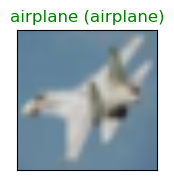

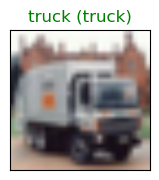

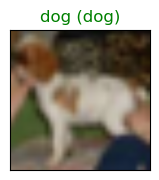

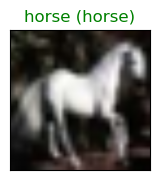

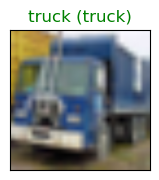

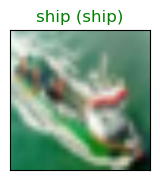

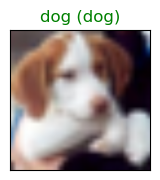

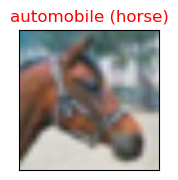

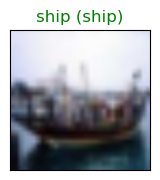

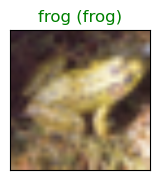

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()
images.numpy()

# move model inputs to cuda, if GPU available
if use_gpu:
    images = images.cuda()

# get sample outputs
output = model_transfer(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels

for idx in np.arange(20):
    fig = plt.figure(figsize=(25, 4))
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.show()

# Performance


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_transfer(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('---Performance of transferred model---')
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

---Performance of transferred model---
Accuracy of airplane : 76 %
Accuracy of automobile : 79 %
Accuracy of  bird : 40 %
Accuracy of   cat : 66 %
Accuracy of  deer : 74 %
Accuracy of   dog : 62 %
Accuracy of  frog : 79 %
Accuracy of horse : 66 %
Accuracy of  ship : 87 %
Accuracy of truck : 75 %
